### Sentiment Analysis using BERT Model to Improve Accuracy

##### BERT stands for Bidirectional Encoder Representations from Transformers.

### Setup


In [42]:
# !pip install -q -U watermark

In [43]:
# !pip install -qq transformers

In [44]:
# %reload_ext watermark
# %watermark -v -p numpy,pandas,torch,transformers

### Libraries

In [45]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data Loading from "Google Drive"

In [46]:
import numpy as np
import pandas as pd
import os
import math

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
### Change the path here to read data

list_of_df = []

for file_name in os.listdir(r'drive/My Drive/FYP/Twitter Data/'):
  data = pd.read_csv(r'drive/My Drive/FYP/Twitter Data/' + file_name , encoding='latin-1' , names = ['sentiment', 'id1' , 'Date' , 'query' , 'name', 'text'])
  list_of_df.append(data)

data = pd.concat(list_of_df, ignore_index=True)

In [48]:
# Drop columns unnecassry
data = data.drop(['id1' , 'Date' , 'query' , 'name'] , axis=1)

In [49]:
data

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1600010,4,Just woke up. Having no school is the best fee...
1600011,4,TheWDB.com - Very cool to hear old Walt interv...
1600012,4,Are you ready for your MoJo Makeover? Ask me f...
1600013,4,Happy 38th Birthday to my boo of alll time!!! ...


In [50]:
data.shape

(1600015, 2)

In [51]:
def to_sentiment(rating):
  rating = int(rating)
  if rating == 0:
    return 0
  elif rating == 4:
    return 1

data['sentiment'] = data.sentiment.apply(to_sentiment)

#### Here 0 is "Negative" and 1 is "Positive"

class_names = [0, 1]

In [52]:
data

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1600010,1,Just woke up. Having no school is the best fee...
1600011,1,TheWDB.com - Very cool to hear old Walt interv...
1600012,1,Are you ready for your MoJo Makeover? Ask me f...
1600013,1,Happy 38th Birthday to my boo of alll time!!! ...


In [53]:
# rows = data[:1500]

In [54]:
# rows

### Data Preprocessing


In [55]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [56]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [57]:
MAX_LEN = 160

The tokenizer will be doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model.

In [58]:
class T_SentimentDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

### Splitting the Data

In [59]:
df_train, df_test = train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [60]:
df_train.shape, df_val.shape, df_test.shape

((1440013, 2), (80001, 2), (80001, 2))

In [61]:
df_train = df_train[:1500]
df_val = df_val[:1500]
df_test = df_test[:1500]

##### Creating the dataloader

In [62]:
def data_loader(df, tokenizer, max_len, batch_size):
  ds = T_SentimentDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [63]:
BATCH_SIZE = 16

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [64]:
df = next(iter(train_data_loader))
df.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

### Sentiment Analysis using BERT and Hugging Face

In [65]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [66]:
output = bert_model(
  input_ids=df['input_ids'], 
  attention_mask=df['attention_mask']
)
output.last_hidden_state
output.pooler_output

tensor([[-0.6242,  0.4197,  0.9996,  ...,  0.9999, -0.8521,  0.9835],
        [-0.4164,  0.3635,  0.9981,  ...,  0.9995, -0.9659,  0.9851],
        [-0.6707,  0.4216,  0.9997,  ...,  0.9999, -0.8078,  0.9842],
        ...,
        [-0.5446,  0.4483,  0.9996,  ...,  0.9999, -0.9118,  0.9808],
        [-0.5515,  0.3962,  0.9995,  ...,  0.9999, -0.8398,  0.9777],
        [-0.5614,  0.4111,  0.9993,  ...,  0.9998, -0.7833,  0.9725]],
       grad_fn=<TanhBackward0>)

#### Creating a Classifier that uses bert model

In [67]:
class Classifier_Sentiment(nn.Module):

  def __init__(self, n_classes):
    super(Classifier_Sentiment, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [68]:
model = Classifier_Sentiment(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [69]:
input_ids = df['input_ids'].to(device)
attention_mask = df['attention_mask'].to(device)

In [70]:
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 160])
torch.Size([16, 160])


##### Applying softmax function to the outputs, to get the predicted probabilities from our trained model

In [71]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3144, 0.6856],
        [0.3479, 0.6521],
        [0.5716, 0.4284],
        [0.3407, 0.6593],
        [0.7675, 0.2325],
        [0.4245, 0.5755],
        [0.4231, 0.5769],
        [0.6060, 0.3940],
        [0.6489, 0.3511],
        [0.6561, 0.3439],
        [0.5747, 0.4253],
        [0.6356, 0.3644],
        [0.3803, 0.6197],
        [0.4585, 0.5415],
        [0.5636, 0.4364],
        [0.3251, 0.6749]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### We can also apply reLu or other activation functions

In [72]:
# F.relu(model(input_ids, attention_mask))

## Training

In [73]:
### Batch size = 16
### Learning Rate (Adam): 2e-5

EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

###### *Helper function* for training our model for one epoch

In [74]:
def train_one_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

*Helper Function* to evaluate the model on a given data loader

In [75]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

##### Training loop using above two helper functions.

In [76]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')

  train_acc, train_loss = train_one_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Training   loss {train_loss} Accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Validation loss {val_loss} Accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
Training   loss 0.621771976034692 Accuracy 0.66
Validation loss 0.5098334703039615 Accuracy 0.74

Epoch 2/5
Training   loss 0.3541878396843342 Accuracy 0.8486666666666667
Validation loss 0.5801428734780626 Accuracy 0.7733333333333333

Epoch 3/5
Training   loss 0.17265830417361824 Accuracy 0.9386666666666666
Validation loss 0.9566958647994126 Accuracy 0.7713333333333333

Epoch 4/5
Training   loss 0.05900174627907852 Accuracy 0.984
Validation loss 1.2116782372282382 Accuracy 0.7586666666666666

Epoch 5/5
Training   loss 0.02083199415194921 Accuracy 0.9953333333333333
Validation loss 1.2891154244289476 Accuracy 0.7593333333333333

CPU times: user 7min 38s, sys: 1min 54s, total: 9min 32s
Wall time: 9min 35s


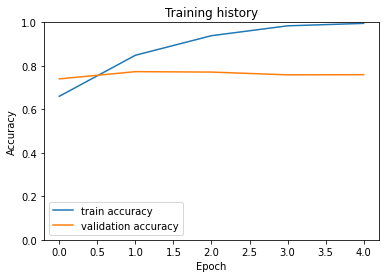

In [77]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evaluation

In [78]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7833333333333333

### Predicting on a single tweet/post


In [96]:
review_text = "I love Twitter! Best app ever!!!"
# review_text = "Sanctions on Pakistan"
# review_text = "Imran Khan is our leader"
# review_text = "Imran Khan is corrupt!"

In [97]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

In [98]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Post text: {review_text}')

if (class_names[prediction] == 1):
  print(f'Sentiment  : Positive')
elif (class_names[prediction] == 0):
  print(f'Sentiment  : Negative')

Post text: I love Twitter! Best app ever!!!
Sentiment  : Positive
